In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

import pandas as pd
import numpy as np
import random

from RoadDataset import RoadDataset
from MultiRoadDataset import MultiRoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_datasets_path = "../notebooks/datasets/train/"
sub_dirs = os.listdir(train_datasets_path)
train_dataset_paths = [[train_datasets_path + sub_dir + "/" + sub_dir + ".csv", train_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
train_dataset_paths

[['../notebooks/datasets/train/Sun Dec 27 18_09_33 2020/Sun Dec 27 18_09_33 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 18_09_33 2020/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 17_46_56 2020/Sun Dec 27 17_46_56 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 17_46_56 2020/frames/'],
 ['../notebooks/datasets/train/Sun Feb 21 21:50:50 2021/Sun Feb 21 21:50:50 2021.csv',
  '../notebooks/datasets/train/Sun Feb 21 21:50:50 2021/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 18_01_53 2020/Sun Dec 27 18_01_53 2020.csv',
  '../notebooks/datasets/train/Sun Dec 27 18_01_53 2020/frames/'],
 ['../notebooks/datasets/train/Wed Dec 30 17_34_37 2020/Wed Dec 30 17_34_37 2020.csv',
  '../notebooks/datasets/train/Wed Dec 30 17_34_37 2020/frames/'],
 ['../notebooks/datasets/train/Sun Jan 10 11:31:18 2021/Sun Jan 10 11:31:18 2021.csv',
  '../notebooks/datasets/train/Sun Jan 10 11:31:18 2021/frames/'],
 ['../notebooks/datasets/train/Sun Dec 27 18_25_24 2020/Sun Dec 27 18_25_24 

In [4]:
val_datasets_path = "../notebooks/datasets/validation/"
sub_dirs = os.listdir(val_datasets_path)
val_dataset_paths = [[val_datasets_path + sub_dir + "/" + sub_dir + ".csv", val_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
val_dataset_paths

[['../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv',
  '../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/frames/'],
 ['../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv',
  '../notebooks/datasets/validation/Nacht-Schneechaos/frames/']]

In [5]:
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
my_batch_size = 16

In [6]:
multi_train_dataset = MultiRoadDataset(column_names, batch_size=my_batch_size)

for train_dataset_path in train_dataset_paths:
    multi_train_dataset.addRoadDataset(train_dataset_path[0], train_dataset_path[1])
    

Reading csv file: ../notebooks/datasets/train/Sun Dec 27 18_09_33 2020/Sun Dec 27 18_09_33 2020.csv
Loaded dataset with 8096 samples
Reading csv file: ../notebooks/datasets/train/Sun Dec 27 17_46_56 2020/Sun Dec 27 17_46_56 2020.csv
Loaded dataset with 3775 samples
Reading csv file: ../notebooks/datasets/train/Sun Feb 21 21:50:50 2021/Sun Feb 21 21:50:50 2021.csv
Failed to read csv file!
Loaded dataset with 0 samples
Reading csv file: ../notebooks/datasets/train/Sun Dec 27 18_01_53 2020/Sun Dec 27 18_01_53 2020.csv
Loaded dataset with 7060 samples
Reading csv file: ../notebooks/datasets/train/Wed Dec 30 17_34_37 2020/Wed Dec 30 17_34_37 2020.csv
Loaded dataset with 3112 samples
Reading csv file: ../notebooks/datasets/train/Sun Jan 10 11:31:18 2021/Sun Jan 10 11:31:18 2021.csv
Loaded dataset with 17985 samples
Reading csv file: ../notebooks/datasets/train/Sun Dec 27 18_25_24 2020/Sun Dec 27 18_25_24 2020.csv
Loaded dataset with 2793 samples
Reading csv file: ../notebooks/datasets/train/

In [7]:
len(multi_train_dataset)

33574

In [8]:
multi_train_dataset.clean()

Cleaning dataset. Starting with 8096 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 389 rows for reason: High SWA (> +180/ < -180 deg)
Removing 1666 rows for reason: Low speed (< 25 km/h)
Removing 141 rows for reason: Left blinker on
Removing 42 rows for reason: Right blinker on
5855 samples remaining.
Cleaning dataset. Starting with 3775 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 425 rows for reason: High SWA (> +180/ < -180 deg)
Removing 862 rows for reason: Low speed (< 25 km/h)
Removing 90 rows for reason: Left blinker on
Removing 221 rows for reason: Right blinker on
2174 samples remaining.
Cleaning dataset. Starting with 0 samples.
Removing 0 rows for reason: No frame after cam latency compensation
Removing 0 rows for reason: High SWA (> +180/ < -180 deg)
Removing 0 rows for reason: Low speed (< 25 km/h)
Removing 0 rows for reason: Left blinker on
Removing 0 rows for reason: Right blinker on
0 sampl

Removing 75 rows for reason: Right blinker on
5788 samples remaining.
Cleaning dataset. Starting with 15174 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 361 rows for reason: High SWA (> +180/ < -180 deg)
Removing 540 rows for reason: Low speed (< 25 km/h)
Removing 105 rows for reason: Left blinker on
Removing 644 rows for reason: Right blinker on
13521 samples remaining.
Cleaning dataset. Starting with 0 samples.
Removing 0 rows for reason: No frame after cam latency compensation
Removing 0 rows for reason: High SWA (> +180/ < -180 deg)
Removing 0 rows for reason: Low speed (< 25 km/h)
Removing 0 rows for reason: Left blinker on
Removing 0 rows for reason: Right blinker on
0 samples remaining.
Cleaning dataset. Starting with 31859 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 689 rows for reason: High SWA (> +180/ < -180 deg)
Removing 2788 rows for reason: Low speed (< 25 km/h)
Removing 312 rows for reason

In [9]:
stats = multi_train_dataset.get_csv().describe()
stats = stats.transpose()
print(stats)

                         count       mean        std      min     25%     50%  \
steering_wheel_angle  447939.0  -1.123429  18.070421 -179.310  -4.450  -0.630   
speed                 447939.0  71.365565  31.197547   25.017  48.701  64.387   
blink_l               447938.0   0.000000   0.000000    0.000   0.000   0.000   
blink_r               447938.0   0.000000   0.000000    0.000   0.000   0.000   

                         75%      max  
steering_wheel_angle   2.380  179.620  
speed                 84.971  205.158  
blink_l                0.000    0.000  
blink_r                0.000    0.000  


In [10]:
multi_train_dataset.balance()

Balancing dataset. Starting with 5855 samples.
[28, 85, 33, 121, 148, 197, 351, 842, 1556, 984, 390, 339, 357, 97, 72, 52, 26, 16]
155
1918 samples remaining.
Balancing dataset. Starting with 2174 samples.
[20, 93, 65, 61, 130, 126, 171, 233, 195, 196, 251, 180, 76, 101, 48, 50, 28, 27]
173
1861 samples remaining.
Balancing dataset. Starting with 5734 samples.
[18, 32, 101, 144, 186, 318, 344, 338, 1483, 1201, 495, 274, 222, 110, 76, 68, 32, 32]
182
2251 samples remaining.
Balancing dataset. Starting with 226 samples.
[1, 12, 6, 37, 19, 33, 16, 13, 15, 16, 33, 0, 0, 0, 0, 0, 0, 0]
0
0 samples remaining.
Balancing dataset. Starting with 17191 samples.
[74, 111, 192, 247, 392, 589, 948, 2037, 5990, 3328, 1069, 387, 363, 282, 207, 136, 70, 81]
472
5374 samples remaining.
Balancing dataset. Starting with 1707 samples.
[20, 26, 25, 25, 24, 58, 142, 220, 495, 230, 95, 158, 67, 42, 31, 0, 0, 0]
44
545 samples remaining.
Balancing dataset. Starting with 1927 samples.
[11, 14, 15, 65, 75, 105, 

In [11]:
stats = multi_train_dataset.get_csv().describe()
stats = stats.transpose()
print(stats)

                         count       mean        std     min     25%     50%  \
steering_wheel_angle  102344.0  -1.590705  19.292228 -44.950 -15.970  -0.940   
speed                 102344.0  58.161749  21.311169  25.017  44.392  54.529   
blink_l               102344.0   0.000000   0.000000   0.000   0.000   0.000   
blink_r               102344.0   0.000000   0.000000   0.000   0.000   0.000   

                         75%      max  
steering_wheel_angle  12.710   44.950  
speed                 67.983  205.096  
blink_l                0.000    0.000  
blink_r                0.000    0.000  


In [12]:
len(multi_train_dataset)

6396

In [13]:
val_datasets = []
for val_dataset_path in val_dataset_paths:
    val_dataset = RoadDataset(val_dataset_path[0], val_dataset_path[1], column_names, batch_size=my_batch_size)
    val_dataset.set_lateral_shift_range(0)
    val_dataset.clean()
    print()
    if len(val_dataset) > 0:
        val_datasets.append(val_dataset)
        

Reading csv file: ../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv
Loaded dataset with 10474 samples
Cleaning dataset. Starting with 10474 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 290 rows for reason: High SWA (> +180/ < -180 deg)
Removing 915 rows for reason: Low speed (< 25 km/h)
Removing 66 rows for reason: Left blinker on
Removing 363 rows for reason: Right blinker on
8837 samples remaining.

Reading csv file: ../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv
Loaded dataset with 7527 samples
Cleaning dataset. Starting with 7527 samples.
Removing 3 rows for reason: No frame after cam latency compensation
Removing 486 rows for reason: High SWA (> +180/ < -180 deg)
Removing 1480 rows for reason: Low speed (< 25 km/h)
Removing 19 rows for reason: Left blinker on
Removing 45 rows for reason: Right blinker on
5494 samples remaining.



In [14]:
len(val_datasets)

2

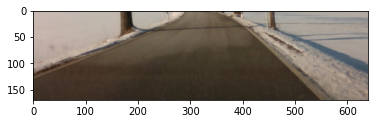

Vel: 76.074 km/h, SWA: -0.9357263411102323 deg


In [15]:
import matplotlib.pyplot as plt
batch = multi_train_dataset[0]
samples = batch[0]
labels = batch[1]

images = samples[0]
velocities = samples[1]



image = images[0]
vel = velocities[0]
swa = labels[0]
swa = multi_train_dataset.denormalize_swa(swa)
plt.figure()
plt.imshow(image)
plt.grid(False)
plt.show()
print("Vel: {} km/h, SWA: {} deg".format(vel*250, swa))

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate, ELU, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Dropout, BatchNormalization

ch, row, col = 3, 170, 640

frame_input = Input(shape=(row, col, ch), name='frame_in')
velocity_input = Input(shape=(1,), name='velocity_in')

# Image branch
x = Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch), name='frame_normalize')(frame_input)
x = MaxPooling2D(pool_size=(2,3), strides=(2,3), padding='valid', name='frame_downsample')(x)
    
x = Conv2D(filters=24, kernel_size=(5,5), strides=(3,3), activation='elu')(x)
#x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    
x = Conv2D(filters=36, kernel_size=(5,5), strides=(3, 3), activation='elu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    
#x = Conv2D(filters=48, kernel_size=(5,5), strides=(2, 2), activation='elu')(x)

#x = Conv2D(filters=64, kernel_size=(3,3), strides=(2, 1), activation='elu')(x)

x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='elu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(50, activation='elu')(x)

x = Model(inputs=frame_input, outputs = x)

# Velocity branch
y = Dense(1, activation='linear')(velocity_input)
y = Model(inputs=velocity_input, outputs = y)


# Combine
combined = concatenate([x.output, y.output])

#combined = Dense(100, activation='elu')(combined)

#combined = Dense(50, activation='elu')(combined)

combined = Dense(10, activation='elu')(combined)

combined = Dense(1, activation='linear', name='swa_out')(combined)

model = Model(inputs=[x.input, y.input], outputs=combined)



model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame_in (InputLayer)           [(None, 170, 640, 3) 0                                            
__________________________________________________________________________________________________
frame_normalize (Lambda)        (None, 170, 640, 3)  0           frame_in[0][0]                   
__________________________________________________________________________________________________
frame_downsample (MaxPooling2D) (None, 85, 213, 3)   0           frame_normalize[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 27, 70, 24)   1824        frame_downsample[0][0]           
____________________________________________________________________________________________

In [18]:
import numpy as np
import matplotlib.pylab as plt


def get_smoothness_score(series):
    
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

    smooth = running_mean(series, 9)
    diff = series[4:-4] - smooth
    
    smoothness = 1/np.mean(np.abs(diff))
    print(smoothness)
    return smoothness

In [19]:
from tensorflow.keras.preprocessing.image import img_to_array
def dataset_thumbs(dataset):
    
    thumbs = 7
    frames = dataset.get_batch_size()*len(dataset)-1
    
    print("Dataset contains {} frames".format(frames))

    plt.figure(figsize=(15,3))
    for i in range(thumbs):
        framenr = frames//thumbs*i
        print("Getting frame {}".format(framenr))
        sample = dataset.get_sample(framenr)
        frame = sample['frame']
        frame = frame/255
        #frame = img_to_array(dataset.get_frame(frames//thumbs*i)[0])/255
        
        sample = dataset.get_sample(framenr, crop=True)
        cropped_frame = sample['frame']
        cropped_frame = cropped_frame/255
        plt.subplot(2,thumbs,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(frame)
        plt.subplot(2,thumbs,i+thumbs+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cropped_frame)
        #plt.xlabel(class_names[train_labels[i]])
    plt.show()

Starting Epoch 1 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset dataset_ma_norm_swa: 0.479455226212589
Dataset dataset_ma_norm_swa: 0.49659686187803703
Dataset dataset_ma_norm_swa: 0.48051094248555604
Dataset dataset_ma_norm_swa: 0.5075701587664205
Dataset dataset_ma_norm_swa: 0.5000957863447267
Dataset dataset_ma_norm_swa: 0.5017927528398483
Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Datas

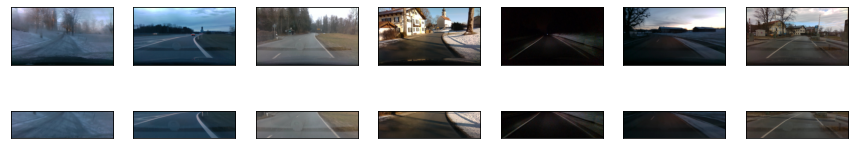

Dataset Mean Absolute Normalized SWA: 0.49238848546534525
6396/6396 [==============================] - 584s 91ms/step - loss: 0.0645 - mse: 0.0645 - mae: 0.1832
Model quality: 62.8%
Predictions: [[-0.7315592]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.314576771239295
Predictions: [[-0.7315592]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.314576771239295
Predictions: [[-0.7315592]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.314576771239295
Predictions: [[-0.7315592]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.314576771239295
Predictions: [[-0.7315592]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.314576771239295



Starting Epoch 2 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203


Dataset dataset_ma_norm_swa: 0.5000957863447267
Dataset dataset_ma_norm_swa: 0.5017927528398483
Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.478385728

6396/6396 [==============================] - 546s 85ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1275
Model quality: 74.1%
Predictions: [[0.20689617]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): 2.5755726690421623
Predictions: [[0.20689617]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): 2.5755726690421623
Predictions: [[0.20689617]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): 2.5755726690421623
Predictions: [[0.20689617]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): 2.5755726690421623
Predictions: [[0.20689617]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): 2.5755726690421623



Starting Epoch 9 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset dataset

Dataset dataset_ma_norm_swa: 0.5017927528398483
Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.4783857283340564
Dataset dataset_ma_norm_swa: 0.489195781

6396/6396 [==============================] - 545s 85ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1370
Model quality: 72.2%
Predictions: [[-0.25154683]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -3.4703056933739918
Predictions: [[-0.25154683]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -3.4703056933739918
Predictions: [[-0.25154683]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -3.4703056933739918
Predictions: [[-0.25154683]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -3.4703056933739918
Predictions: [[-0.25154683]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -3.4703056933739918



Starting Epoch 16 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Data

Dataset dataset_ma_norm_swa: 0.5000957863447267
Dataset dataset_ma_norm_swa: 0.5017927528398483
Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.478385728

6396/6396 [==============================] - 544s 85ms/step - loss: 0.0523 - mse: 0.0523 - mae: 0.1348
Model quality: 72.6%
Predictions: [[-0.65132856]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -25.07095644586584
Predictions: [[-0.65132856]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -25.07095644586584
Predictions: [[-0.65132856]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -25.07095644586584
Predictions: [[-0.65132856]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -25.07095644586584
Predictions: [[-0.65132856]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -25.07095644586584



Starting Epoch 23 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset d

Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.4783857283340564
Dataset dataset_ma_norm_swa: 0.48919578188841756
Dataset dataset_ma_norm_swa: 0.51110457

6396/6396 [==============================] - 556s 87ms/step - loss: 0.0334 - mse: 0.0334 - mae: 0.1239
Model quality: 74.8%
Predictions: [[-0.205276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -2.546015661940576
Predictions: [[-0.205276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -2.546015661940576
Predictions: [[-0.205276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -2.546015661940576
Predictions: [[-0.205276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -2.546015661940576
Predictions: [[-0.205276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -2.546015661940576



Starting Epoch 30 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset dataset_ma_

Dataset dataset_ma_norm_swa: 0.4790962276870115
Dataset dataset_ma_norm_swa: 0.4959595149428938
Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.4783857283340564
Dataset dataset_ma_norm_swa: 0.48919578188841756
Dataset dataset_ma_norm_swa: 0.51110457

6396/6396 [==============================] - 545s 85ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1167
Model quality: 76.3%
Predictions: [[-0.73484844]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.80876444349084
Predictions: [[-0.73484844]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.80876444349084
Predictions: [[-0.73484844]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.80876444349084
Predictions: [[-0.73484844]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.80876444349084
Predictions: [[-0.73484844]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -35.80876444349084



Starting Epoch 37 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset d

Dataset dataset_ma_norm_swa: 0.4752552978346696
Dataset dataset_ma_norm_swa: 0.4905102237070003
Dataset dataset_ma_norm_swa: 0.4924244645982388
Dataset dataset_ma_norm_swa: 0.4828032785791148
Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.4783857283340564
Dataset dataset_ma_norm_swa: 0.48919578188841756
Dataset dataset_ma_norm_swa: 0.5111045792002699
Dataset dataset_ma_norm_swa: 0.47998332879514605
6396/6396 [===========================

Predictions: [[-0.6022182]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -20.242836981139874
Predictions: [[-0.6022182]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -20.242836981139874
Predictions: [[-0.6022182]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -20.242836981139874
Predictions: [[-0.6022182]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -20.242836981139874



Starting Epoch 44 for all datasets
Dataset dataset_ma_norm_swa: 0.49796524936352893
Dataset dataset_ma_norm_swa: 0.4908205776595874
Dataset dataset_ma_norm_swa: 0.49253962647306065
Dataset dataset_ma_norm_swa: 0.4853172231640458
Dataset dataset_ma_norm_swa: 0.505639651660203
Dataset dataset_ma_norm_swa: 0.5074250345550023
Dataset dataset_ma_norm_swa: 0.479455226212589
Dataset dataset_ma_norm_swa: 0.49659686187803703
Dataset dataset_ma_norm_swa: 0.48051094248555604
Dataset dataset_ma_norm_swa: 0.5075701587664205
Dataset dataset_ma_norm_swa: 0.5000957863447267


Dataset dataset_ma_norm_swa: 0.4864627676798697
Dataset dataset_ma_norm_swa: 0.505321841575943
Dataset dataset_ma_norm_swa: 0.48613490130734377
Dataset dataset_ma_norm_swa: 0.4783904413671825
Dataset dataset_ma_norm_swa: 0.48679822830445946
Dataset dataset_ma_norm_swa: 0.5030315727223875
Dataset dataset_ma_norm_swa: 0.4914865070270836
Dataset dataset_ma_norm_swa: 0.4771699204859127
Dataset dataset_ma_norm_swa: 0.5115802284303022
Dataset dataset_ma_norm_swa: 0.4884213545553183
Dataset dataset_ma_norm_swa: 0.5077132887538492
Dataset dataset_ma_norm_swa: 0.498249936642662
Dataset dataset_ma_norm_swa: 0.4783857283340564
Dataset dataset_ma_norm_swa: 0.48919578188841756
Dataset dataset_ma_norm_swa: 0.5111045792002699
Dataset dataset_ma_norm_swa: 0.47998332879514605
6396/6396 [==============================] - 556s 87ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.1083
Model quality: 78.0%
Predictions: [[-0.56133276]]
Ground-truth (deg): -17.47
Prediction (denormed swa (deg)): -16.8870826272491

In [ ]:
model_name = 'v17.2'
epochs = 200

qualities = dict()

multi_train_dataset.denormalize_swa(0.5)

for epoch in range(epochs):
    print("Starting Epoch {} for all datasets".format(epoch+1))
    qualities["epoch-" + str(epoch)] = dict()
    
    naive_norm_mae = multi_train_dataset.get_mean_absolute_normalized_swa()
    if epoch == 0:
        dataset_thumbs(multi_train_dataset)
        print("Dataset Mean Absolute Normalized SWA: {}".format(naive_norm_mae))
    hist = model.fit(multi_train_dataset, epochs=1, verbose=1, workers=4)#, use_multiprocessing=False, workers=1)
    model.save('./trained_models/' + model_name + "_epoch_" + str(epoch+1) + '.h5')
    
    
    model_mae = hist.history['mae'][-1]

    quality = 1 - (model_mae/naive_norm_mae)
    qualities["epoch-" + str(epoch)] = quality
    print("Model quality: {:.1f}%".format(100*quality))
        
    # Predict a couple as a sanity check
    for i in range(5):
        sample_idx = 100#random.randint(0, 10000)
        sample = multi_train_dataset.get_sample(sample_idx, augment=False, crop=True, normalize=False)
        cropped_frame = sample['frame']
        actual_swa = sample['swa']
        v_vehicle = sample['v_vehicle']
        blink_l = sample['blink_l']
        blink_r = sample['blink_r']
        timestamp = sample['filename']
        
        #cropped_frame = np.zeros_like(cropped_frame)
        #v_vehicle = 0
        #actual_swa = 0.5

        test_data = [np.array([cropped_frame]), np.array([v_vehicle/250])]
        predictions = model.predict(test_data)

        #predicted_swa = val_set.denormalize_swa(predictions[0][0])
        predicted_swa = predictions[0][0]
        denormed_pred_swa = multi_train_dataset.denormalize_swa(predicted_swa)
        print("Predictions: " + str(predictions))
        print("Ground-truth (deg): " +str(actual_swa))
        print("Prediction (denormed swa (deg)): " + str(denormed_pred_swa))
        
    print()
    #i = 1
    #for val_set in val_sets:
    #    loss = model.evaluate(val_set, verbose=1)
    #    predictions = model.predict(val_set, verbose=1)
    #    predictions_degrees = [x[0]*90 for x in predictions.tolist()]
    #    get_smoothness_score(predictions_degrees)
    #    #print("Validation Set {} loss: {}".format(i, loss))
    #    i+=1
        
    print()
    print()
    